In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from datetime import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series


from tensorflow.keras.layers import Flatten, TimeDistributed,RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

import os
from numpy.random import seed

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_excel('/Users/stevenmacauda/Downloads/Sample - Superstore.xls')

In [4]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [5]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

In [6]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [7]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

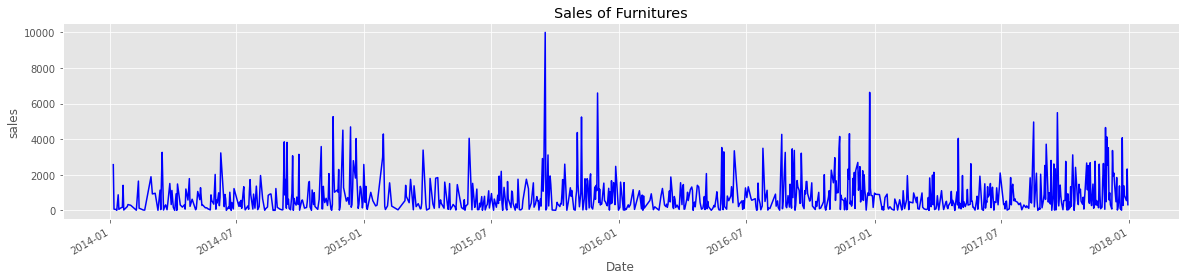

In [8]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furnitures")
plt.show()

In [9]:
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= avg_furniture_sales
#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

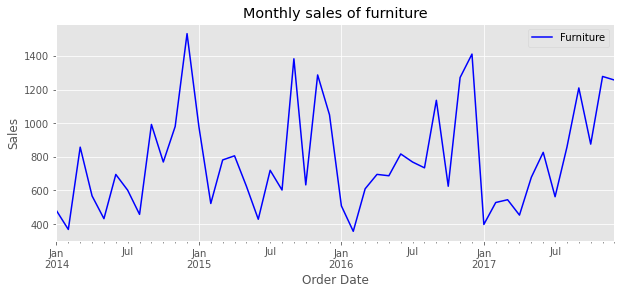

In [10]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

In [11]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [12]:
train, test = np.array(df[:-12]), np.array(df[-12:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [13]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [14]:
dfcnn= np.array(df)
dfcnn= dfcnn.reshape(-1,1)
#Scale data
scaler = MinMaxScaler()
ts = scaler.fit_transform(dfcnn)

In [15]:
#Set the timestep
timestep = 12
X= []
Y=[]
raw_data=ts
for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)
#Set the trainset
X_train = X[:24,:,:]  
Y_train = Y[:24] 
#Set the testset
X_test = X[24:,:,:]  
Y_test= Y[24:]

In [17]:
#define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(12, 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse')


# fit model
cnn_model.fit(X_train, Y_train, epochs=200, verbose=1)

Metal device set to: AMD Radeon Pro Vega 16


2022-08-19 21:30:07.183694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-19 21:30:07.183970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/200


2022-08-19 21:30:09.747337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 7s 7s/step - loss: 0.1863
Epoch 2/200
1/1 [==============================] - 0s 14ms/step - loss: 0.1199
Epoch 3/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0804
Epoch 4/200
1/1 [==============================] - 0s 15ms/step - loss: 0.0777
Epoch 5/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0912
Epoch 6/200
1/1 [==============================] - 0s 17ms/step - loss: 0.0827
Epoch 7/200
1/1 [==============================] - 0s 15ms/step - loss: 0.0699
Epoch 8/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0640
Epoch 9/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0640
Epoch 10/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0650
Epoch 11/200
1/1 [==============================] - 0s 16ms/step - loss: 0.0642
Epoch 12/200
1/1 [==============================] - 0s 18ms/step - loss: 0.0610
Epoch 13/200
1/1 [==============================] - 0s 15ms/ste

1/1 [==============================] - 0s 15ms/step - loss: 3.1603e-06
Epoch 102/200
1/1 [==============================] - 0s 13ms/step - loss: 1.2986e-06
Epoch 103/200
1/1 [==============================] - 0s 15ms/step - loss: 1.1967e-06
Epoch 104/200
1/1 [==============================] - 0s 15ms/step - loss: 1.9645e-06
Epoch 105/200
1/1 [==============================] - 0s 17ms/step - loss: 1.0351e-06
Epoch 106/200
1/1 [==============================] - 0s 18ms/step - loss: 9.0058e-07
Epoch 107/200
1/1 [==============================] - 0s 18ms/step - loss: 1.8088e-06
Epoch 108/200
1/1 [==============================] - 0s 17ms/step - loss: 1.5214e-06
Epoch 109/200
1/1 [==============================] - 0s 15ms/step - loss: 1.1161e-06
Epoch 110/200
1/1 [==============================] - 0s 16ms/step - loss: 1.6149e-06
Epoch 111/200
1/1 [==============================] - 0s 17ms/step - loss: 1.6576e-06
Epoch 112/200
1/1 [==============================] - 0s 18ms/step - loss: 1.096

1/1 [==============================] - 0s 14ms/step - loss: 2.7473e-06
Epoch 198/200
1/1 [==============================] - 0s 17ms/step - loss: 3.0439e-05
Epoch 199/200
1/1 [==============================] - 0s 17ms/step - loss: 4.4539e-05
Epoch 200/200
1/1 [==============================] - 0s 19ms/step - loss: 2.2408e-05


In [18]:
# Validate data
preds = cnn_model.predict(X_test)
preds=np.array(preds)
preds=preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)


Y_test=np.asanyarray(Y_test)  
Y_test=Y_test.reshape(-1,1) 
Y_test = scaler.inverse_transform(Y_test)


Y_train=np.asanyarray(Y_train)  
Y_train=Y_train.reshape(-1,1) 
Y_train = scaler.inverse_transform(Y_train)

2022-08-19 21:30:37.312916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 612ms/step


In [19]:
cnn= performance(Y_test,preds)
cnn_predict= preds.reshape((12,))
cnn

{'MSE': 41342.41, 'RMSE': 203.33, 'MAPE': 23.22}

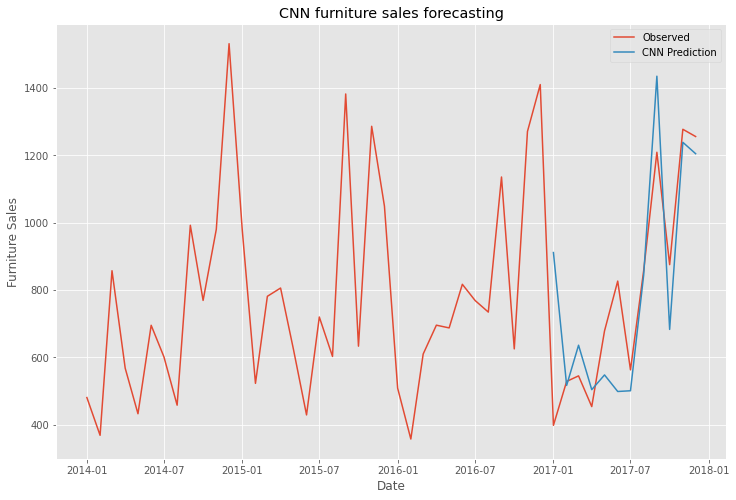

In [20]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed")
plt.plot(df[36:].index,preds,label="CNN Prediction")
plt.title('CNN furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()